# Tarea 5. Predicción del valor de las acciones en la bolsa

**Elaborado por:** 
    
    - Jherson Guzman Ramirez / jheguzmanram@unal.edu.co

*Curso de Inteligencia Artificial / 2023-I* 

*Universidad Nacional de Colombia - Sede Bogotá*

**Profesor: Alvaro Montenegro**

15 de junio de 2023

[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guzmandb/Diplomado_Ciencia_Datos/blob/main/Tareas/Tarea5_JhersonGuzman.ipynb)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
import tensorflow as tf

#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

2023-06-15 22:51:33.438250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versión de Tensorflow:  2.12.0


In [3]:
import yfinance as yf

# Define la fecha de inicio y fin para el rango mensual deseado
start_date = '2012-05-18'
end_date = '2023-06-15'

# Obtén los datos mensuales para cada acción
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'NFLX', 'TSLA', 'NVDA']
data = pd.DataFrame()

for ticker in tickers:
    stock = yf.download(tickers=ticker, start=start_date, end=end_date, interval='1d', progress=False)
    stock = stock[['Close']]
    stock.columns = [ticker]
    data = pd.concat([data, stock], axis=1)

data = data.round(2)  # Redondea los precios a 2 decimales

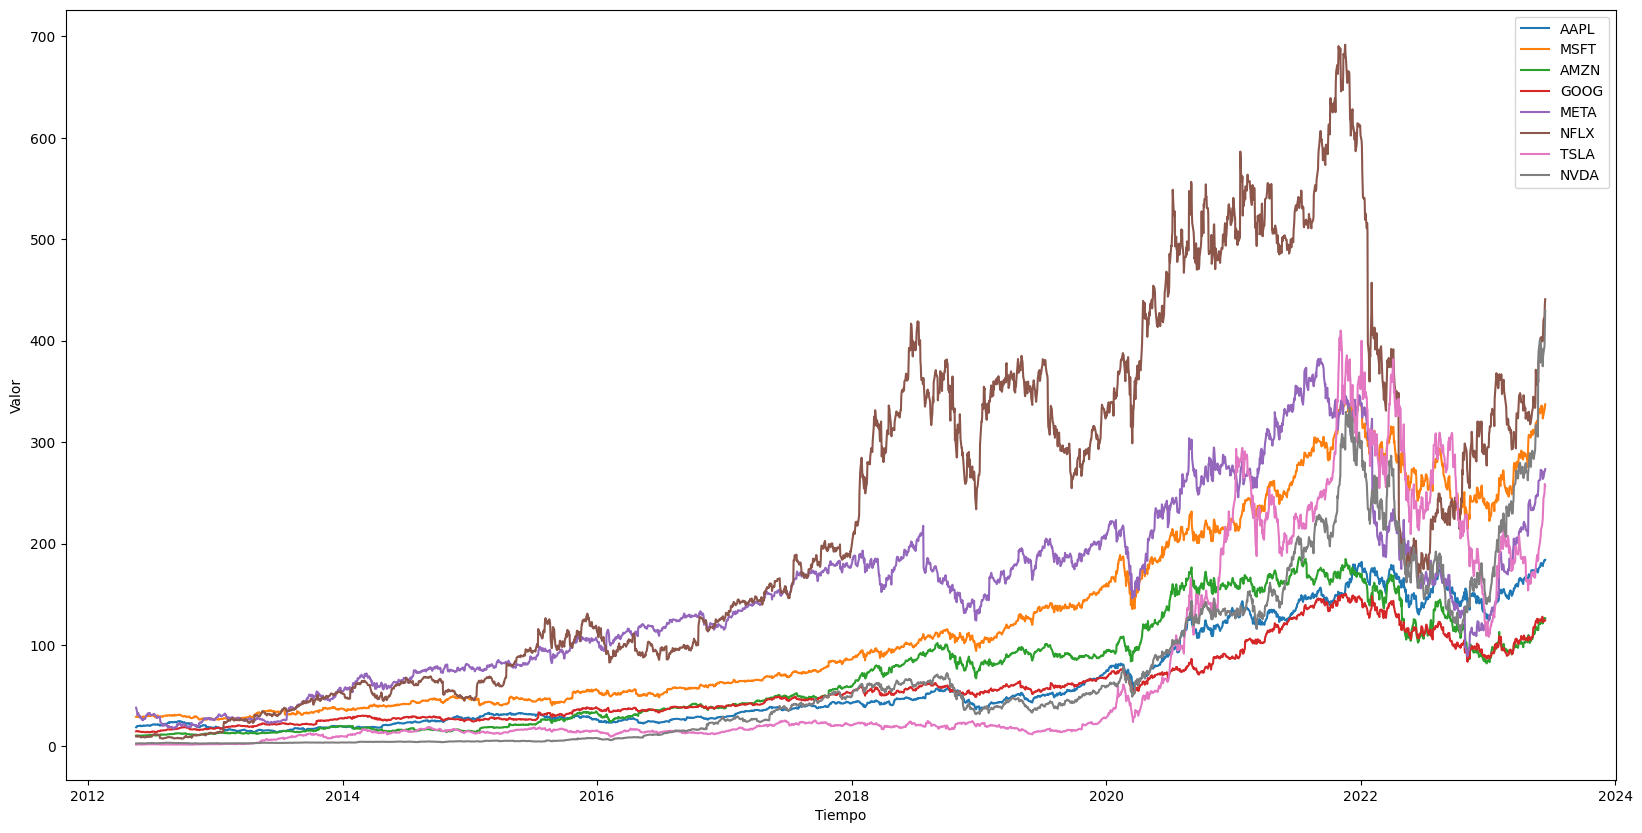

In [4]:
def plot_dataframe(df):
    # Obtener las columnas del DataFrame
    columns = df.columns

    # Crear una figura y un conjunto de subgráficos
    fig, ax = plt.subplots()

    # Iterar sobre cada columna y graficar la serie de tiempo correspondiente
    for column in columns:
        ax.plot(df.index, df[column], label=column)

    # Añadir una leyenda
    ax.legend()

    # Configurar las etiquetas de los ejes
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Valor')

    # Mostrar el gráfico
    plt.show()

plot_dataframe(data)

In [5]:
data = data['GOOG']
len_data = len(data)

2786 = 2507 + 279


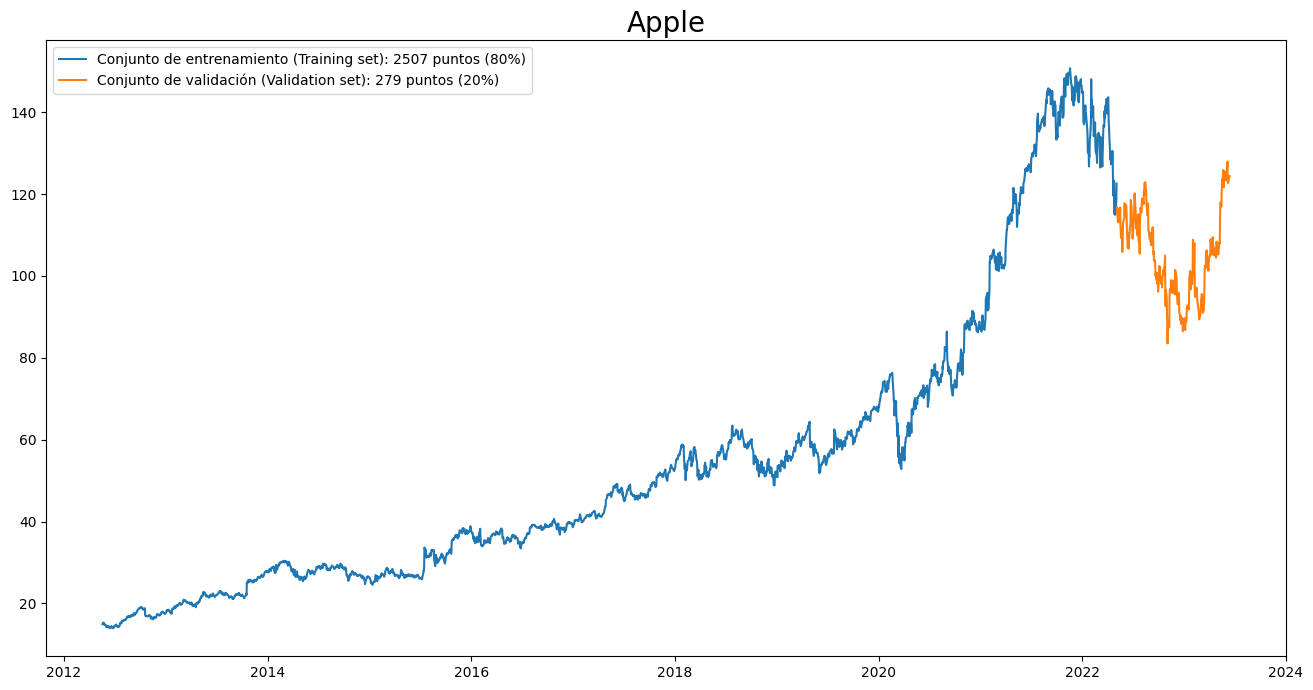

In [6]:
len_train = int(len_data*0.90) 
len_test = len_data- len_train 
print (len_data, '=', len_train, '+',len_test)
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data[len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) 
plt.title("Apple", size = 20)
plt.legend()
plt.show()

In [7]:
# creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = np.array(dataset).reshape(-1, 1)  
scaled_data = scaler.fit_transform(dataset)
dataset = np.squeeze(scaled_data, axis=1)

In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)

In [9]:
# hiperparámetros para crear las secuencias
past_history = 50 # tamaño secuencias de entrada (Ventana)
future_target = 1 # días adelante
TRAIN_SPLIT = int(len_data*0.90) #nuḿero de datos entrenamiento

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
#
#secuencias de validación
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [10]:
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.2, name= 'Dropout_01')(inputs)
# x = LSTM(units=units, name='LSTM_layer')(x)
x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(x)
x = Dropout(0.4, name= 'Dropout_02')(x)
x = LSTM(units=units//2, name='LSTM_layer_2')(x)
x = Dropout(0.4, name= 'Dropout_03')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

2023-06-15 22:52:56.405795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 22:52:56.407706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 22:52:56.409765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 50, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50, 50)            10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50, 50)            0         
                                                                 
 LSTM_layer_2 (LSTM)         (None, 25)                7600      
                                                                 
 Dropout_03 (Dropout)        (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)           

2023-06-15 22:52:57.272970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 22:52:57.274814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 22:52:57.276502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))

In [12]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/10


2023-06-15 22:53:01.474481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 22:53:01.483846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 22:53:01.493352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

68/70 [============================>.] - ETA: 0s - loss: 0.0031

2023-06-15 22:53:06.806695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 22:53:06.808075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 22:53:06.809386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

70/70 [==============================] - 7s 33ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 2/10
70/70 [==============================] - 2s 24ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 3/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 4/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 5/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 6/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0047 - val_loss: 0.0169
Epoch 7/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0030 - val_loss: 0.0122
Epoch 8/10
70/70 [==============================] - 2s 24ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 9/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 10/10
70/70 [==============================] - 2s 25ms/step - loss: 0.0041 - val_loss: 0.0016


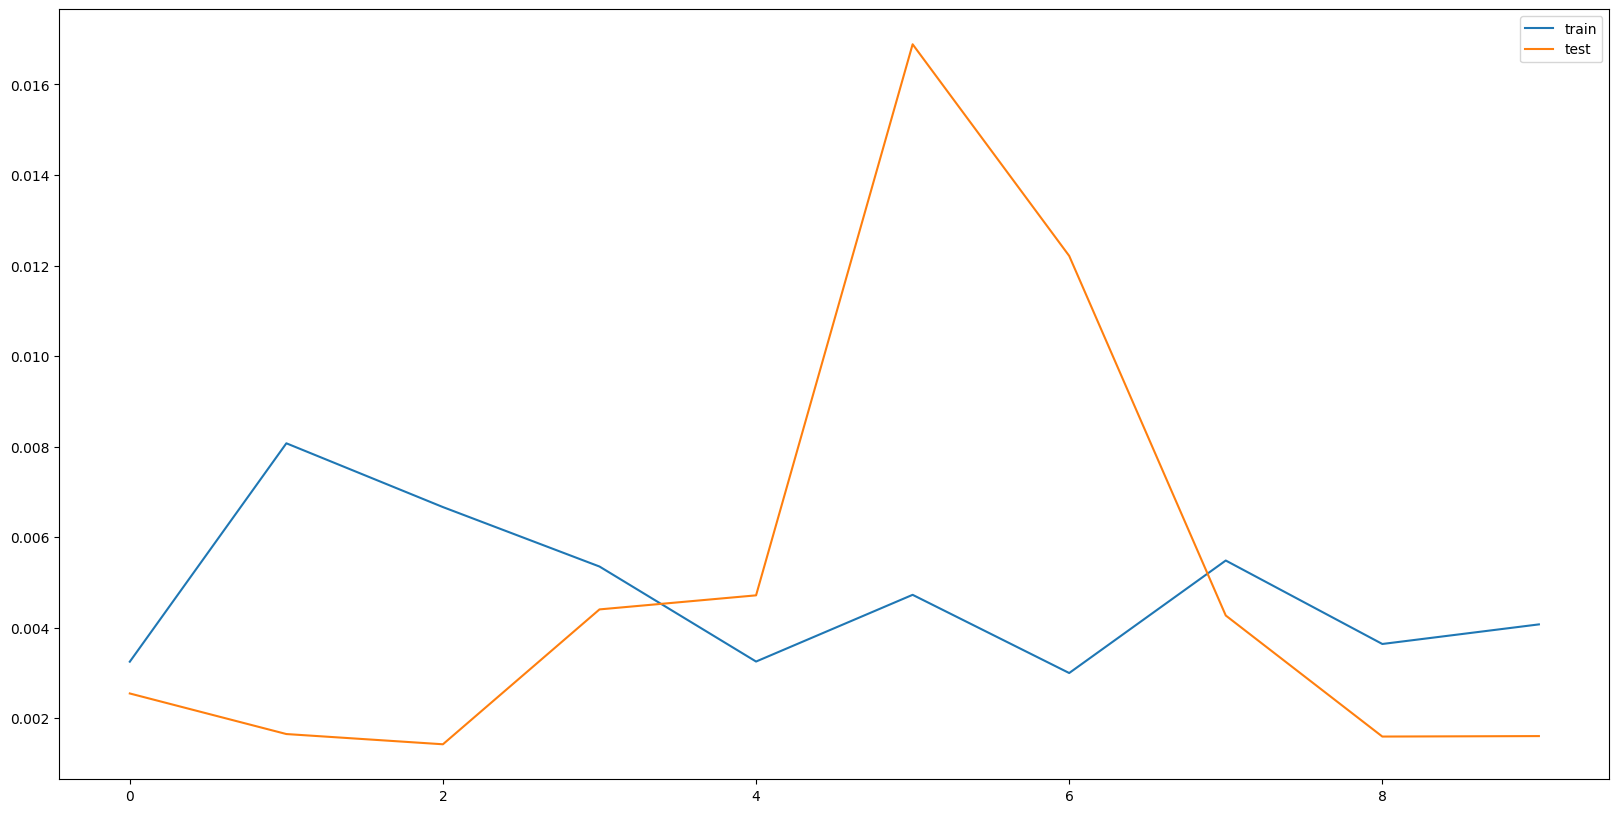

In [13]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()

In [14]:
prediction1 = model_01.predict(X_test)

2023-06-15 22:53:29.136929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 22:53:29.139910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 22:53:29.142265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 3s 17ms/step


In [15]:
y_train_p1 = y_train #np.squeeze(y_train, axis=-1)
y_test_p1 = y_test#np.squeeze(y_test, axis=-1)
y_pred_p1 = np.squeeze(prediction1, axis=-1)

In [16]:
print(y_train_p1.shape)
print(y_test_p1.shape)
print(y_pred_p1.shape)

k=0
for i,j in zip(y_test_p1, y_pred_p1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(2457,)
(228,)
(228,)
0.7367497624095327 0.7531321 -0.01638234246412451
0.7392353242196066 0.75280523 -0.013569908782102402
0.6904013451275677 0.7528504 -0.06244906819488105
0.6893047737407703 0.7532092 -0.06390439993858155
0.6690547554645807 0.75207543 -0.0830206782664984
0.7287082389063526 0.75015986 -0.021451620750934985
0.7359456100592148 0.74711335 -0.01116773699431306
0.7509320856787776 0.7455669 0.005365181133947239
0.7424519336208786 0.7450645 -0.0026125633731399756
0.745522333503911 0.74572474 -0.00020240414028460663


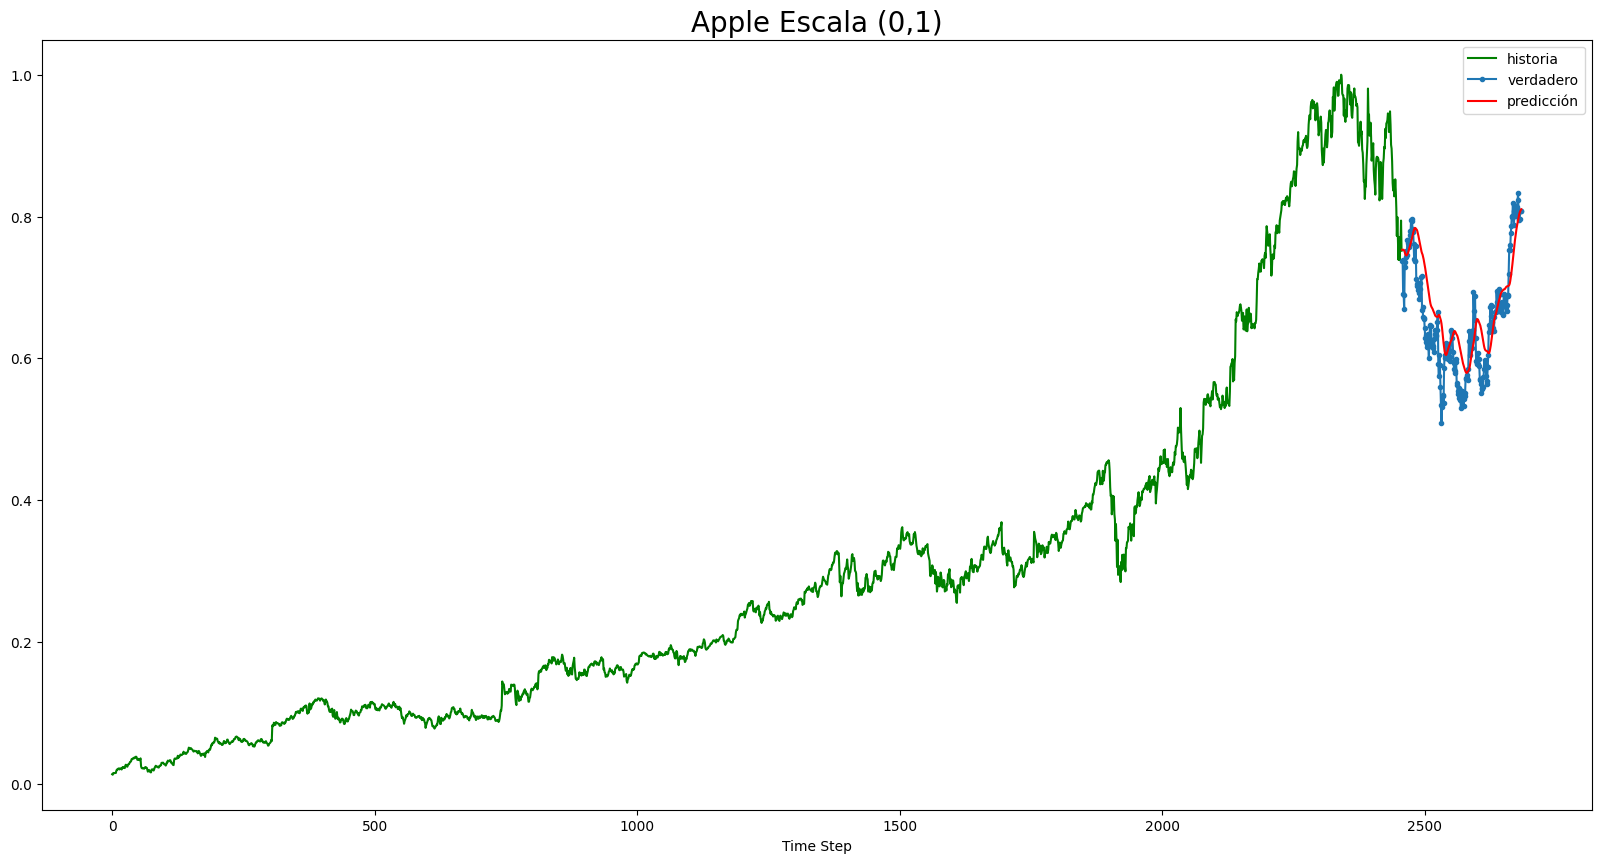

In [17]:
plt.plot(np.arange(0, len(y_train_p1)), y_train_p1, 'g', label="historia")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_test_p1, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p1), len(y_train_p1) + len(y_test_p1)), y_pred_p1, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple Escala (0,1)", size = 20)
plt.legend()
plt.show();